**Author:** Dr. Shahriar Hossain <br>
**Topic of the code:** Knowledge Distillation using Teacher-Student Model <br>
**Video explaining this code:** [https://youtu.be/Z87AXtDBcds](https://youtu.be/Z87AXtDBcds) <br>
**My YT Channel:** https://www.youtube.com/@C4A <br>
**Web:** https://computing4all.com/

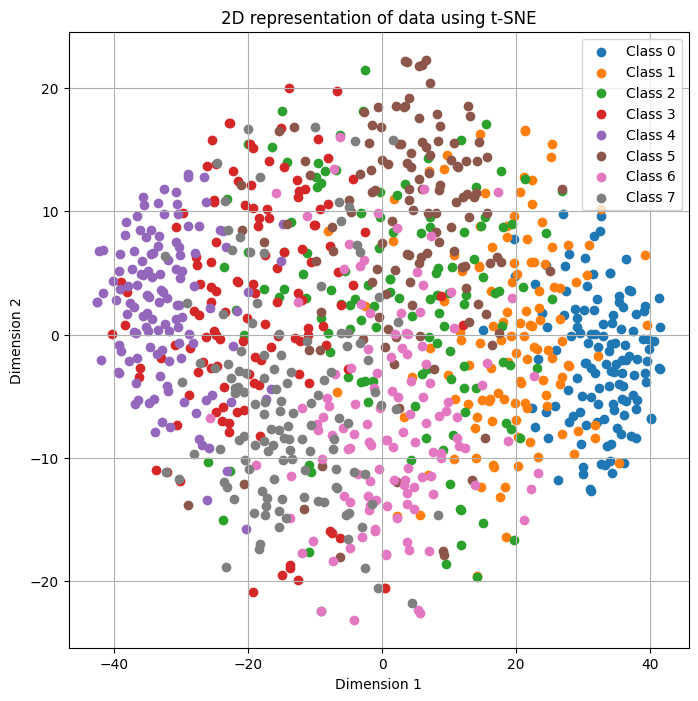

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.utils import shuffle

def shuffle_data_and_labels(data, labels):
    """
    Shuffle data and labels together.

    Args:
    - data (torch.Tensor or np.array): The data array.
    - labels (torch.Tensor or np.array): The labels corresponding to the data.

    Returns:
    - shuffled_data: Shuffled data.
    - shuffled_labels: Shuffled labels corresponding to the shuffled data.
    """

    # Check if the input is a torch tensor
    if torch.is_tensor(data) and torch.is_tensor(labels):
        permuted_indices = torch.randperm(len(data))
        shuffled_data = data[permuted_indices].clone()
        shuffled_labels = labels[permuted_indices].clone()
    else: # Assuming numpy
        permuted_indices = np.random.permutation(len(data))
        shuffled_data = data[permuted_indices]
        shuffled_labels = labels[permuted_indices]
    return shuffled_data, shuffled_labels

def generate_data_20d(num_samples=1000):
    """
    Generates synthetic 20-dimensional data
    using a mixture of Gaussians.
    """
    # 20-dimensional means for the Gaussians
    means = [
        np.array([2, 2, 4, 4, 6, 6, 8, 8, 10, 10, 3, 3, 5, 5, 7, 7, 9, 9, 11, 11]),
        np.array([3, 3, 5, 5, 7, 7, 9, 9, 11, 11, 4, 4, 6, 6, 8, 8, 10, 10, 12, 12]),
        np.array([4, 4, 6, 6, 8, 8, 10, 10, 12, 12, 5, 5, 7, 7, 9, 9, 11, 11, 13, 13]),
        np.array([5, 5, 7, 7, 9, 9, 11, 11, 13, 13, 6, 6, 8, 8, 10, 10, 12, 12, 14, 14]),
        np.array([6, 6, 8, 8, 10, 10, 12, 12, 14, 14, 7, 7, 9, 9, 11, 11, 13, 13, 15, 15]),
        np.array([2, 3, 5, 6, 8, 7, 9, 10, 12, 11, 4, 5, 7, 8, 10, 9, 11, 12, 14, 13]),
        np.array([3, 2, 6, 5, 7, 8, 10, 9, 11, 12, 5, 4, 8, 7, 9, 10, 12, 11, 13, 14]),
        np.array([4, 3, 7, 6, 8, 9, 11, 10, 12, 13, 6, 5, 9, 8, 10, 11, 13, 12, 14, 15]),
    ]

    # Diagonal covariances for simplicity
    cov = np.diag([3.5]*20)

    data = []
    labels = []
    for i, mean in enumerate(means):
        x = np.random.multivariate_normal(mean, cov, num_samples // len(means))
        data.append(x)
        labels.append(np.full((x.shape[0]), i))

    data = np.vstack(data)
    labels = np.hstack(labels)

    # Shuffle data and labels to ensure that
    # the first half contains all labels
    # as well as the second half contains
    # all labels

    dataFull, labelsFull = data, labels
    n_labels = len(np.unique(labelsFull))

    # Split data by labels and shuffle
    split_data = [dataFull[labelsFull == i]
                  for i in range(n_labels)]
    shuffled_data = [shuffle(data)
                     for data in split_data]

    # Split each shuffled data into two halves
    first_half_data = [data[:len(data)//2]
                       for data in shuffled_data]

    second_half_data = [data[len(data)//2:]
                        for data in shuffled_data]

    # Similarly for labels
    first_half_labels = np.concatenate(\
        [np.full(len(data), i)
         for i, data in enumerate(first_half_data)])
    second_half_labels = np.concatenate(\
        [np.full(len(data), i)\
         for i, data in enumerate(second_half_data)])

    # Concatenate the halves first
    first_half_data_combined = np.vstack(first_half_data)
    first_half_labels_combined = np.hstack(first_half_labels)

    second_half_data_combined = np.vstack(second_half_data)
    second_half_labels_combined = np.hstack(second_half_labels)

    # Now shuffle
    first_half_data_shuffled, first_half_labels_shuffled = shuffle_data_and_labels(first_half_data_combined, first_half_labels_combined)
    second_half_data_shuffled, second_half_labels_shuffled = shuffle_data_and_labels(second_half_data_combined, second_half_labels_combined)

    # Concatenate the two shuffled halves to get the shuffled dataset
    dataShuffled = np.vstack([first_half_data_shuffled, second_half_data_shuffled])
    labelsShuffled = np.hstack([first_half_labels_shuffled, second_half_labels_shuffled])

    return dataShuffled, labelsShuffled

# Generate data
dataFull, labelsFull = generate_data_20d()

#Number of labels
n_labels = len(set(labelsFull))

dataForTeacher=dataFull[:int(len(dataFull)/2)] # Get the first half rows
labelsForTeacher=labelsFull[:int(len(dataFull)/2)] # get the first half labels

data=dataFull[-int(len(dataFull)/2):] # Get the last half rows
labels=labelsFull[-int(len(dataFull)/2):] # get the last half labels

# Due to the high dimensionality,
# we are going to use t-SNE to visualize the
# data in two dimensions.

# drawing the tsne of dataFull

from sklearn.manifold import TSNE

# Apply t-SNE to reduce the data to 2D
data_2d = TSNE(n_components=2).fit_transform(dataFull)

# Plot the 2D representation of the data
plt.figure(figsize=(8, 8))
for i in range(n_labels):
    plt.scatter(\
        data_2d[labelsFull == i][:, 0],\
        data_2d[labelsFull == i][:, 1],\
        label=f"Class {i}")
plt.legend()
plt.title("2D representation of data using t-SNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


In [ ]:
print(data.shape, " ", labels.shape)

(500, 20)   (500,)


In [ ]:
print("Class labels: ",set(labels))

Class labels:  {0, 1, 2, 3, 4, 5, 6, 7}


In [ ]:
dataForTeacher.shape

(500, 20)

In [ ]:
set(labelsForTeacher)

{0, 1, 2, 3, 4, 5, 6, 7}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import LabelBinarizer
import numpy as np

In [ ]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.current_device())
  print(torch.cuda.device(0))
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")


0
1
NVIDIA GeForce RTX 3080 Ti


In [ ]:
# Load data in X and labels in y,
# just to follow the variable convention
X=data
y=labels

# Convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

XTeacher = torch.tensor(dataForTeacher,
                        dtype=torch.float32)
yTeacher = torch.tensor(labelsForTeacher,
                        dtype=torch.long)


In [ ]:
# Teacher model
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()

        # Layers similar to Simple/Student but with more nodes
        self.fc1 = nn.Linear(X.shape[1], 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(100, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(200, 300)
        self.bn3 = nn.BatchNorm1d(300)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(300, 500)
        self.bn4 = nn.BatchNorm1d(500)
        self.dropout4 = nn.Dropout(0.3)

        self.fc5 = nn.Linear(500, n_labels)

    def forward(self, x):
        x = torch.sigmoid(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = torch.tanh(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = torch.sigmoid(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = torch.tanh(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        return self.fc5(x)  # Return logits


class Simple(nn.Module):
    def __init__(self):
        super(Simple, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 300)
        self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300, 500)
        self.bn2 = nn.BatchNorm1d(500)
        self.fc3 = nn.Linear(500, n_labels)

    def forward(self, x):
        x = torch.sigmoid(self.bn1(self.fc1(x)))
        x = torch.tanh(self.bn2(self.fc2(x)))
        return self.fc3(x)  # Return logits

class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 300)
        self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300, 500)
        self.bn2 = nn.BatchNorm1d(500)
        self.fc3 = nn.Linear(500, n_labels)

    def forward(self, x):
        x = torch.sigmoid(self.bn1(self.fc1(x)))
        x = torch.tanh(self.bn2(self.fc2(x)))
        return self.fc3(x)  # Return logits


Teacher model epoch:  0 loss: 2.1702165603637695
Teacher model epoch:  100 loss: 0.8637869954109192
Teacher model epoch:  200 loss: 0.7575938701629639
Teacher model epoch:  300 loss: 0.6429405808448792
Teacher model epoch:  400 loss: 0.5477280020713806
Teacher model epoch:  500 loss: 0.4510011374950409
Teacher model epoch:  600 loss: 0.3749810755252838
Teacher model epoch:  700 loss: 0.28154993057250977
Teacher model epoch:  800 loss: 0.25680041313171387
Teacher model epoch:  900 loss: 0.25863465666770935
Teacher model epoch:  1000 loss: 0.18830490112304688
Teacher model epoch:  1100 loss: 0.1407601237297058
Teacher model epoch:  1200 loss: 0.1739896982908249
Teacher model epoch:  1300 loss: 0.150329127907753
Teacher model epoch:  1400 loss: 0.1207781657576561
Teacher model epoch:  1500 loss: 0.136878103017807
Teacher model epoch:  1600 loss: 0.12408318370580673
Teacher model epoch:  1700 loss: 0.10392289608716965
Teacher model epoch:  1800 loss: 0.09579182416200638
Teacher model epoch

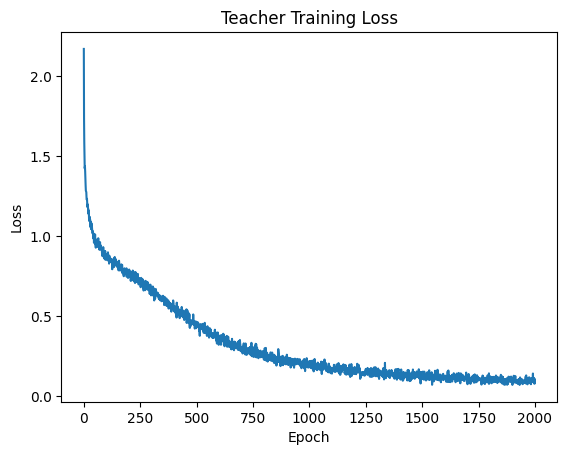

In [ ]:
# Train teacher first using  XTeacher and yTeacher
# To ensure that out teacher model is great, we add all data to it.
X_combined = torch.cat([XTeacher, X], dim=0)
y_combined = torch.cat([yTeacher, y], dim=0)

train_X=X_combined.to(device)
train_y=y_combined.to(device)
teacher = Teacher().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_teacher = optim.Adam(teacher.parameters(), lr=0.005)
# Train teacher model
loss_values = []
for epoch in range(0, 2000):
    optimizer_teacher.zero_grad()
    outputs = teacher(train_X)
    loss = criterion(outputs, train_y)
    loss.backward()
    optimizer_teacher.step()
    loss_values.append(loss.item())
    if (epoch%100==0):
      print("Teacher model epoch: ", epoch, "loss:", loss.item())


import matplotlib.pyplot as plt

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Teacher Training Loss')
plt.show()

In [ ]:
# k-fold cross-validation
skf = StratifiedKFold(n_splits=5)

splitID=0
teacher_accuracies = []
student_accuracies = []
simple_accuracies = []

for train_index, test_index in skf.split(X.cpu(), y.cpu()):
    train_X, test_X = X[train_index].to(device), X[test_index].to(device)
    train_y, test_y = y[train_index].to(device), y[test_index].to(device)

    print(" ******* Fold number: ", splitID, " ******* ")
    splitID=splitID+1

    student = Student().to(device)
    simple_model = Simple().to(device)

    optimizer_student = optim.Adam(student.parameters(), lr=0.01)
    optimizer_simple = optim.Adam(simple_model.parameters(), lr=0.01)

    criterion = nn.CrossEntropyLoss()
    # for distillation loss
    criterion_distill = nn.KLDivLoss(reduction='batchmean')

    # Train simple model
    for epoch in range(1, 1001):
        optimizer_simple.zero_grad()
        outputs = simple_model(train_X)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer_simple.step()
        if (epoch%100==0):
          print("Simple model epoch: ",
                epoch, "loss:",loss.item())

    # Introduce the temperature
    T =7.0 # for example, you can experiment with different values

    # Set alpha value
    # 1.0 means loss associated with hard labels only.
    # 0.0 means distillation loss only
    alpha=0.3
    # Train student model using knowledge distillation
    for epoch in range(1, 1001):
        optimizer_student.zero_grad()
        student_logits = student(train_X)
        teacher_logits = teacher(train_X).detach()

        # Note: We'll use log-softmax for the teacher
        # and softmax for the student
        # To avoid underflow issues when computing
        # this quantity, nn.KLDivLoss expects the
        # argument input (teacher_probs) in the log-space.
        teacher_probs = torch.log_softmax(teacher_logits / T, dim=1)
        student_probs = torch.softmax(student_logits / T, dim=1)

        distillation_loss = \
            criterion_distill(teacher_probs, student_probs)

        hard_target_loss = criterion(student_logits, train_y)

        loss = alpha * hard_target_loss+\
            (1.0 - alpha) * T**2 * distillation_loss

        loss.backward()
        optimizer_student.step()
        if (epoch%100==0):
            print("Student model epoch: ", epoch, "loss:",loss.item())

    # Evaluate the models
    with torch.no_grad():
        teacher_outputs = teacher(test_X)
        teacher_predicted = torch.argmax(teacher_outputs, dim=1)
        teacher_accuracy = (teacher_predicted == test_y).float().mean().item()
        teacher_accuracies.append(teacher_accuracy)

        student_outputs = student(test_X)
        student_predicted = torch.argmax(student_outputs, dim=1)
        student_accuracy = (student_predicted == test_y).float().mean().item()
        student_accuracies.append(student_accuracy)

        simple_outputs = simple_model(test_X)
        simple_predicted = torch.argmax(simple_outputs, dim=1)
        simple_accuracy = (simple_predicted == test_y).float().mean().item()
        simple_accuracies.append(simple_accuracy)

        print("Teacher accuracy:", teacher_accuracy)
        print("Simple model accuracy:", simple_accuracy)
        print("Student accuracy:", student_accuracy)

 ******* Fold number:  0  ******* 
Simple model epoch:  100 loss: 0.002800763351842761
Simple model epoch:  200 loss: 0.0006008620839565992
Simple model epoch:  300 loss: 0.000249808537773788
Simple model epoch:  400 loss: 0.00013442769704852253
Simple model epoch:  500 loss: 8.258126763394102e-05
Simple model epoch:  600 loss: 5.6362623581662774e-05
Simple model epoch:  700 loss: 4.024659574497491e-05
Simple model epoch:  800 loss: 3.0180592148099095e-05
Simple model epoch:  900 loss: 2.3709333618171513e-05
Simple model epoch:  1000 loss: 1.924482057802379e-05
Student model epoch:  100 loss: 2.5694055557250977
Student model epoch:  200 loss: 1.785046935081482
Student model epoch:  300 loss: 1.7844159603118896
Student model epoch:  400 loss: 1.590341567993164
Student model epoch:  500 loss: 1.781201958656311
Student model epoch:  600 loss: 1.681699514389038
Student model epoch:  700 loss: 1.6270679235458374
Student model epoch:  800 loss: 1.8632521629333496
Student model epoch:  900 lo

In [ ]:
# Average and print the losses
print("Average Teacher Accuracy:",
      sum(teacher_accuracies) / len(teacher_accuracies))
print("Average Simple model Accuracy:",
      sum(simple_accuracies) / len(simple_accuracies))
print("Average Student Accuracy:",
      sum(student_accuracies) / len(student_accuracies))

Average Teacher Accuracy: 0.9639999628067016
Average Simple model Accuracy: 0.529999989271164
Average Student Accuracy: 0.7039999842643738
